<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/04.neural_networks/04bis_regularization_of_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If you run this on Google Colab, change the environment to TPU or GPU

In [4]:
!pip install tensorflow

In [5]:

# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot


# Import the visualization and neural network libraries I prepared for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/neural_network_tools.py
from visualization import plot_conf_mat
from neural_network_tools import enforce_reproducibility, make_sequential_model, train_model


# The following is to be able to mount Google Drive
from google.colab import drive

import os
from os.path import isfile

from functools import partial

--2025-09-28 20:26:40--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13023 (13K) [text/plain]
Saving to: ‘visualization.py’

visualization.py    100%[===================>]  12.72K  --.-KB/s    in 0.001s  

2025-09-28 20:26:40 (20.6 MB/s) - ‘visualization.py’ saved [13023/13023]

--2025-09-28 20:26:40--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/neural_network_tools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connec

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import datetime # Import the datetime module


from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report




### Mount your Google Drive

Training a neural network may take long time and you don't want to do it every time. Once you've trained a model, it is better to save it, so that you can use it immediately for prediction next times.

Unfortunately, the storage on Google is reset every time. You need to store all persistent data in you Google Drive.

You need therefore to mount your Google Drive, which you will use later in this notebook

In [7]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it

# Replace the following folder with some folder inside your google drive
my_path = drive_path + \
  'tsp/teaching/data-science-for-networks/img-from-code/04.neural-networks/'

Mounted at /content/gdrive


# Network Bandwidth Dataset


Load the training and tes dataset that we saved in our google drive in the previoyus notebook

In [5]:
X_train = pd.read_csv(my_path + 'X_train.csv', header=None).values
X_test = pd.read_csv(my_path + 'X_test.csv', header=None).values
y_train = pd.read_csv(my_path + 'y_train.csv', header=None).values
y_test = pd.read_csv(my_path + 'y_test.csv', header=None).values

Let's see if we can improve the deep architecture we analyzed in the previous notebook. We found that it is worse than the smaller architecture, however
*will the deep architecture perform better if we regularize it?*

We use dropout regularization

In [6]:
num_of_classes = y_train.shape[1]
sample_size = X_train.shape[1]
deep_architecture = [8, 8 ,8, 8, 8, 8, 8, 8, 8, num_of_classes]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693 (2.71 KB)

 Trainable params: 693 (2.71 KB)

 Non-trainable params: 0 (0.00 B)

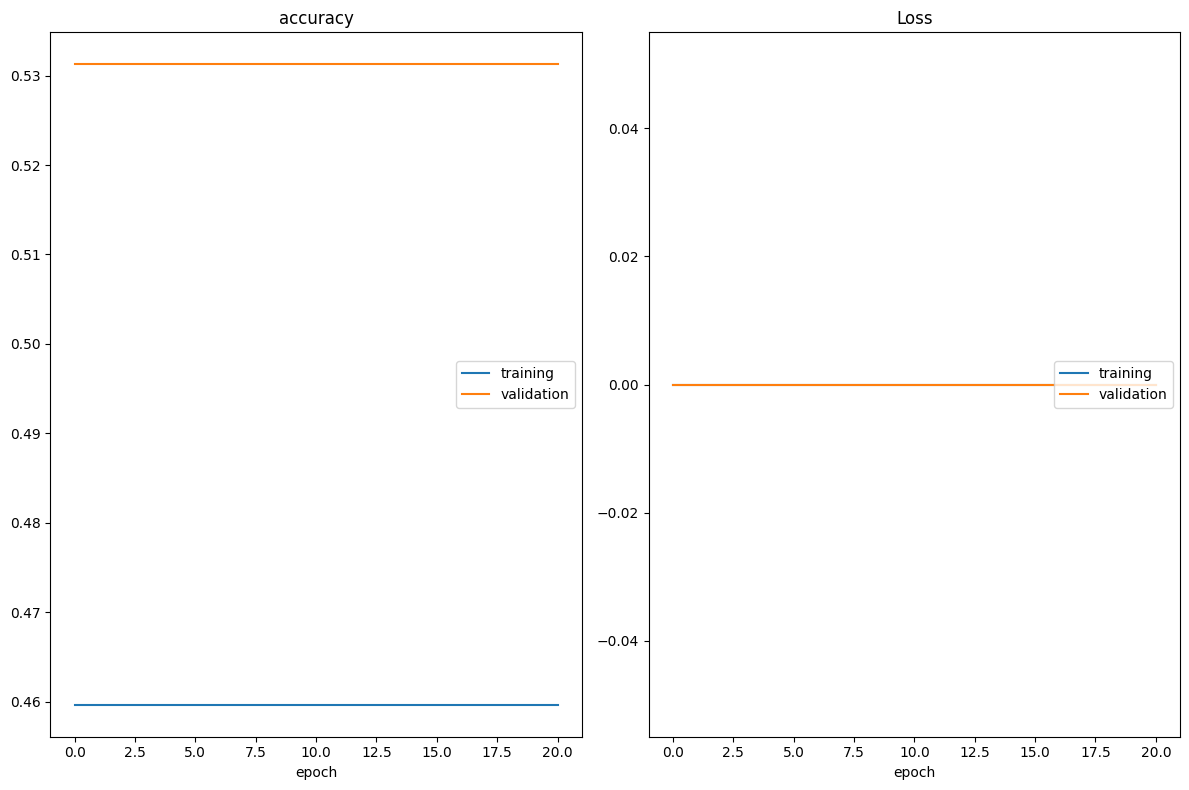

accuracy
	training         	 (min:    0.460, max:    0.460, cur:    0.460)
	validation       	 (min:    0.531, max:    0.531, cur:    0.531)
Loss
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.4599 - loss: 0.0000e+00 - val_accuracy: 0.5312 - val_loss: 0.0000e+00
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 1.


In [14]:
model = make_sequential_model(sample_size, deep_architecture,
                              learning_rate=0.01, dropout_keep_prob=0.5)
nn_file = my_path + 'nn-deep-nodropoutkp-lr_0.01.keras'
history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=800,
                      overwrite=True, patience=20)

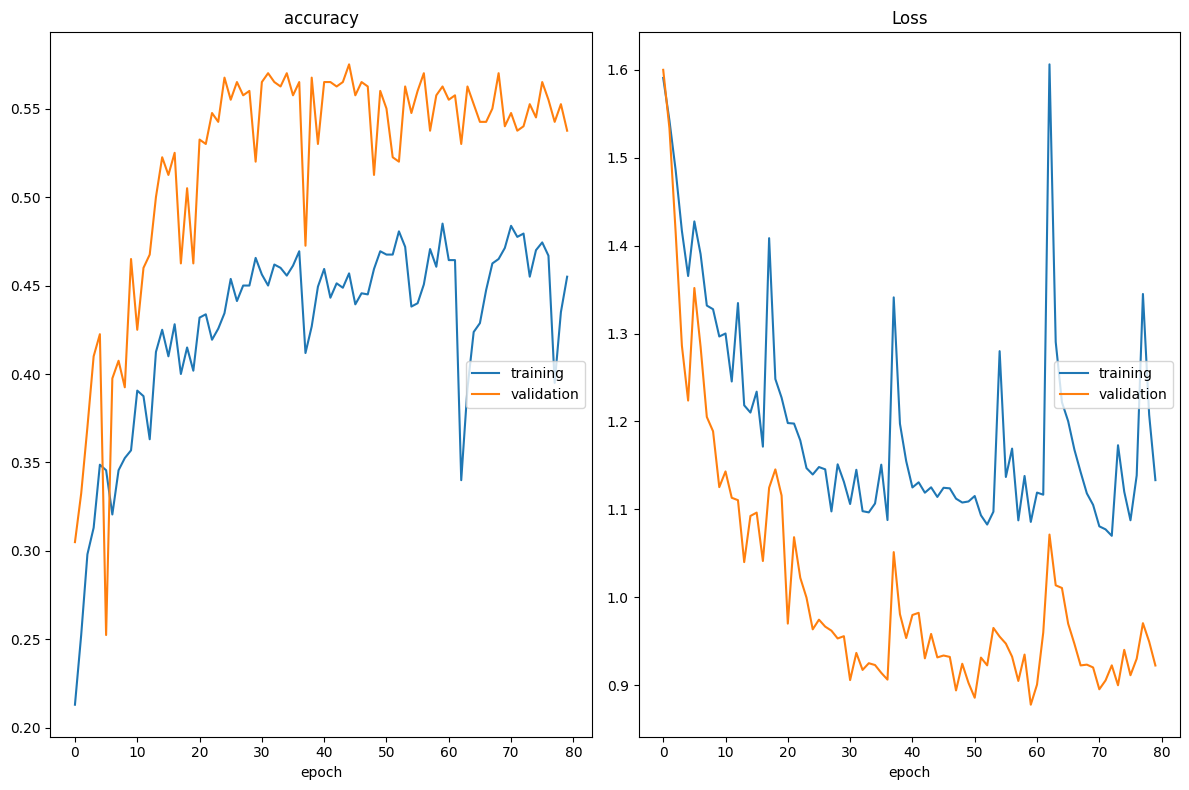

accuracy
	training         	 (min:    0.213, max:    0.485, cur:    0.455)
	validation       	 (min:    0.252, max:    0.575, cur:    0.538)
Loss
	training         	 (min:    1.070, max:    1.606, cur:    1.133)
	validation       	 (min:    0.878, max:    1.600, cur:    0.923)
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4529 - loss: 1.1701 - val_accuracy: 0.5375 - val_loss: 0.9226
Epoch 80: early stopping
Restoring model weights from the end of the best epoch: 60.


In [7]:
model = make_sequential_model(sample_size, deep_architecture,
                              learning_rate=0.01, dropout_keep_prob=0.5)
nn_file = my_path + 'nn-deep-dropoutkp_0.5-lr_0.01.keras'
history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=800,
                      overwrite=True, patience=20)

Learning rate might be too high

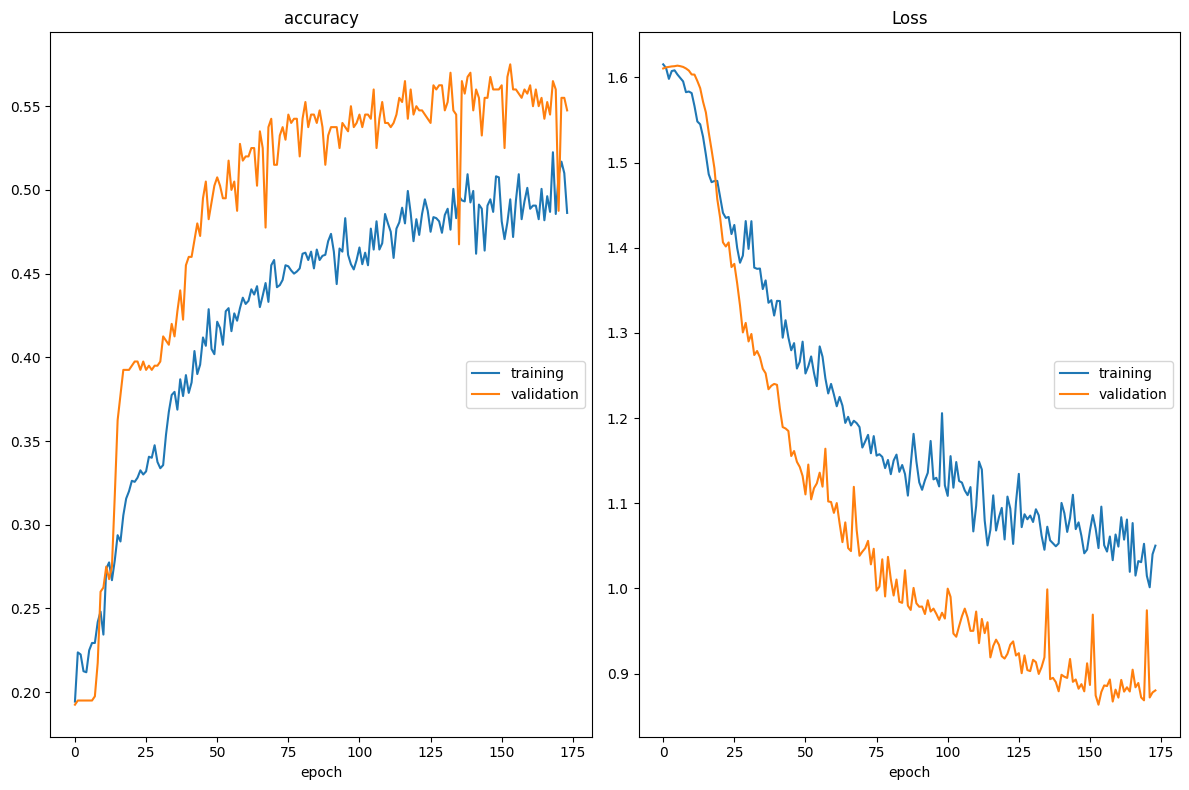

accuracy
	training         	 (min:    0.194, max:    0.522, cur:    0.486)
	validation       	 (min:    0.192, max:    0.575, cur:    0.548)
Loss
	training         	 (min:    1.001, max:    1.615, cur:    1.050)
	validation       	 (min:    0.864, max:    1.614, cur:    0.880)
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4824 - loss: 1.0501 - val_accuracy: 0.5475 - val_loss: 0.8803
Epoch 174: early stopping
Restoring model weights from the end of the best epoch: 154.


In [8]:
nn_file = my_path + 'nn-deep-dropoutkp_0.5-lr_0.001.keras'
model = make_sequential_model(sample_size, deep_architecture,
                              learning_rate=0.001, dropout_keep_prob=0.5)
history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=800,
                      overwrite=True, patience=20
                      )

A bit better. But maybe we are exagerating in dropping neurons. Let us try with a higher `keep_probability`

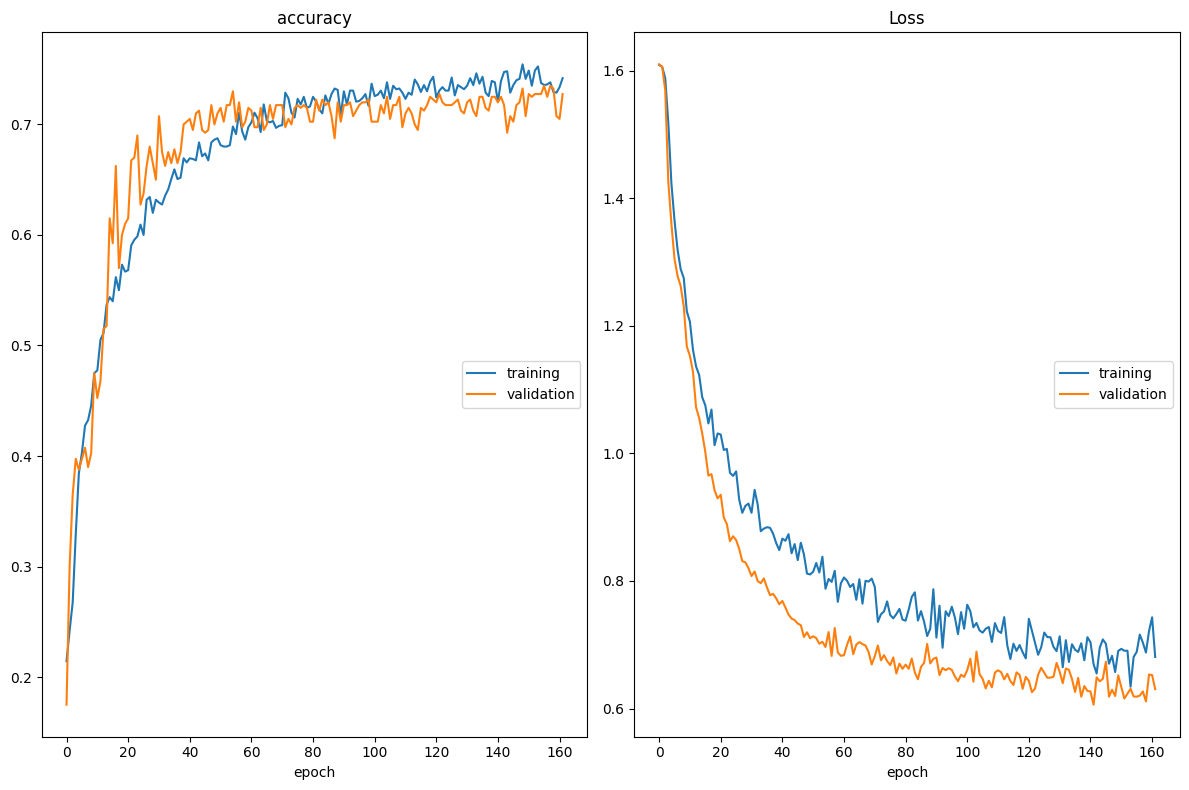

accuracy
	training         	 (min:    0.214, max:    0.754, cur:    0.742)
	validation       	 (min:    0.175, max:    0.735, cur:    0.728)
Loss
	training         	 (min:    0.634, max:    1.609, cur:    0.681)
	validation       	 (min:    0.606, max:    1.610, cur:    0.630)
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7478 - loss: 0.7205 - val_accuracy: 0.7275 - val_loss: 0.6304
Epoch 162: early stopping
Restoring model weights from the end of the best epoch: 142.


In [9]:
nn_file = my_path + 'nn-deep-dropoutkp_0.8-lr_0.001.keras'
model = make_sequential_model(sample_size, deep_architecture,
                              learning_rate=0.001, dropout_keep_prob=0.8)
history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=800,
                      overwrite=True, patience=20
                      )

Let's be a bit more patient (since dropout perturns a bit the training phase, we need to let it explore more)

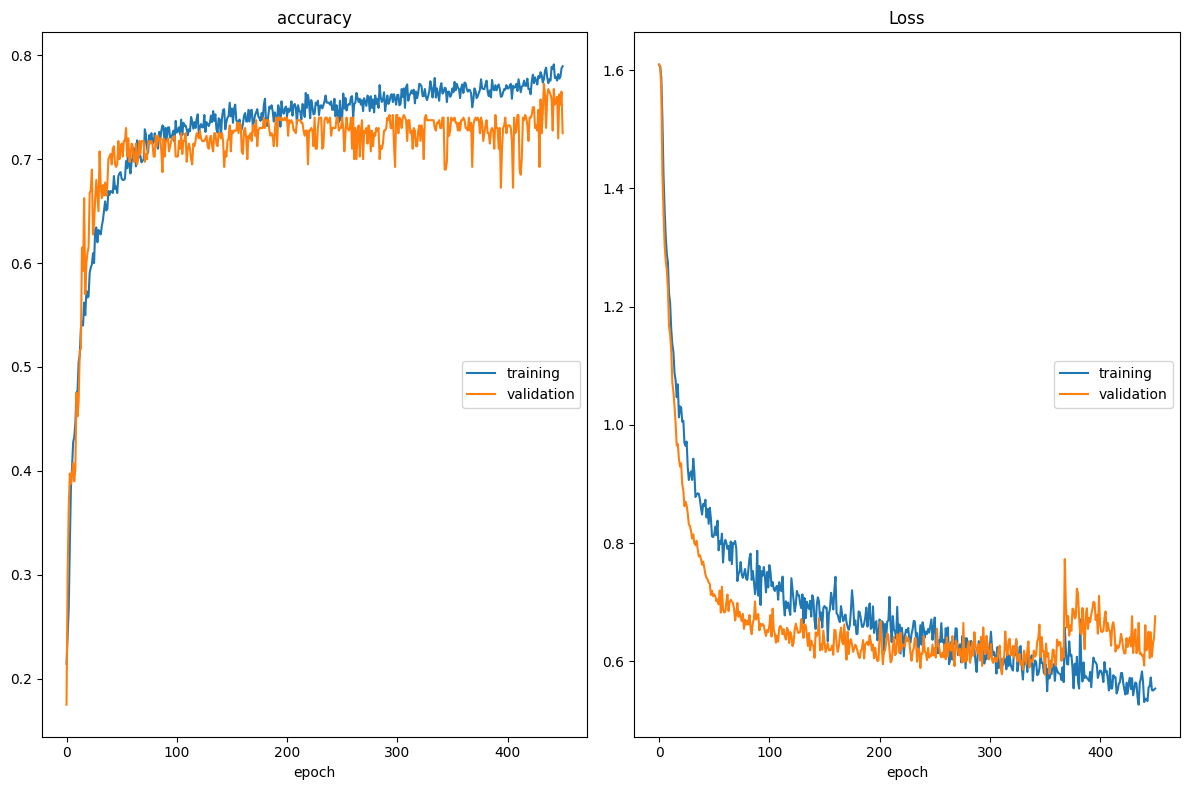

accuracy
	training         	 (min:    0.214, max:    0.791, cur:    0.789)
	validation       	 (min:    0.175, max:    0.772, cur:    0.725)
Loss
	training         	 (min:    0.527, max:    1.609, cur:    0.554)
	validation       	 (min:    0.577, max:    1.610, cur:    0.676)
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8019 - loss: 0.5610 - val_accuracy: 0.7250 - val_loss: 0.6762
Epoch 451: early stopping
Restoring model weights from the end of the best epoch: 351.


In [10]:
nn_file = my_path + 'nn-deep-dropoutkp_0.8-lr_0.001.keras'
model = make_sequential_model(sample_size, deep_architecture,
                              learning_rate=0.001, dropout_keep_prob=0.8)
history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=800,
                      overwrite=True, patience=100
                      )

We are a bit better, but still worse than the small neural network.

# Another dataset

In this dataset dropout might not be useful (but we can never be sure). In any case, let us try to apply dropout on another dataset, as in [this video](https://youtu.be/lcI8ukTUEbo?si=s6JCqJwYgocrMH1C).

In [8]:
!wget https://raw.githubusercontent.com/codebasics/deep-learning-keras-tf-tutorial/refs/heads/master/13_dropout_layer/sonar_dataset.csv

--2025-09-28 20:27:09--  https://raw.githubusercontent.com/codebasics/deep-learning-keras-tf-tutorial/refs/heads/master/13_dropout_layer/sonar_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87776 (86K) [text/plain]
Saving to: ‘sonar_dataset.csv.1’

sonar_dataset.csv.1 100%[===================>]  85.72K  --.-KB/s    in 0.01s   

2025-09-28 20:27:09 (6.17 MB/s) - ‘sonar_dataset.csv.1’ saved [87776/87776]



In [9]:
sonar_df = pd.read_csv("./sonar_dataset.csv", header=None)
X = sonar_df.drop(60, axis=1)
y = sonar_df[60]
y = pd.get_dummies(y, drop_first=True)
y.sample(5) # R --> 1 and M --> 0
seed_ = 32
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state= seed_)


We are performing binary classification. Therefore: **output neurons = 1**, **loss function = binary cross entropy**.

In [10]:
num_of_output_neurons = 1 # Since we are talking about a binary calassification
sample_size = X_train.shape[1]
deep_architecture = [60, 30 ,15, num_of_output_neurons]
model = make_sequential_model(sample_size, deep_architecture,
                              loss_fun="binary_crossentropy",
                              learning_rate=0.0001)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,971 (23.32 KB)

 Trainable params: 5,971 (23.32 KB)

 Non-trainable params: 0 (0.00 B)

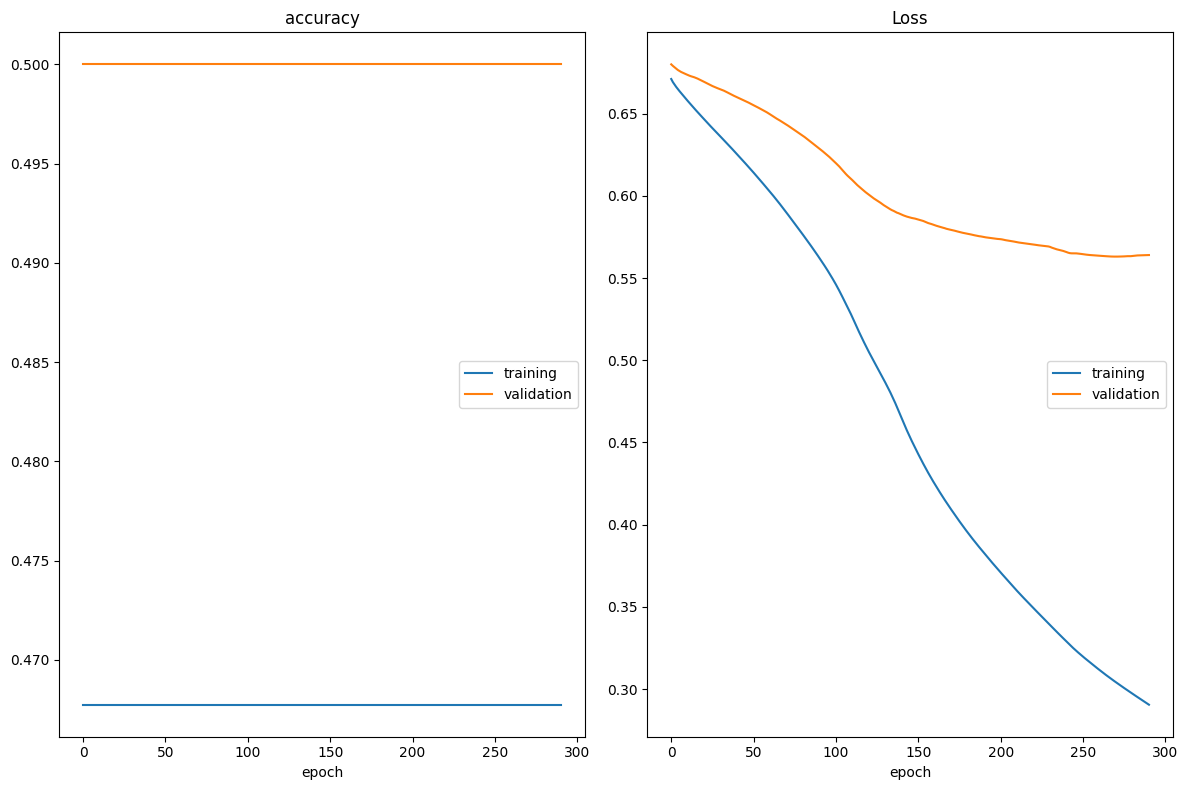

accuracy
	training         	 (min:    0.468, max:    0.468, cur:    0.468)
	validation       	 (min:    0.500, max:    0.500, cur:    0.500)
Loss
	training         	 (min:    0.290, max:    0.671, cur:    0.290)
	validation       	 (min:    0.563, max:    0.680, cur:    0.564)
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.4725 - loss: 0.2913 - val_accuracy: 0.5000 - val_loss: 0.5640
Epoch 291: early stopping
Restoring model weights from the end of the best epoch: 271.


In [11]:
nn_file = my_path + 'nn-sonar-no-dropout-lr_0.0001.keras'
history = train_model(model, nn_file, X_train, y_train, seed=seed_, max_epochs=800,
                      overwrite=True, patience=20)

After 200 epochs, the model starts to overfit.

Let us apply the dropout to avoid overfit

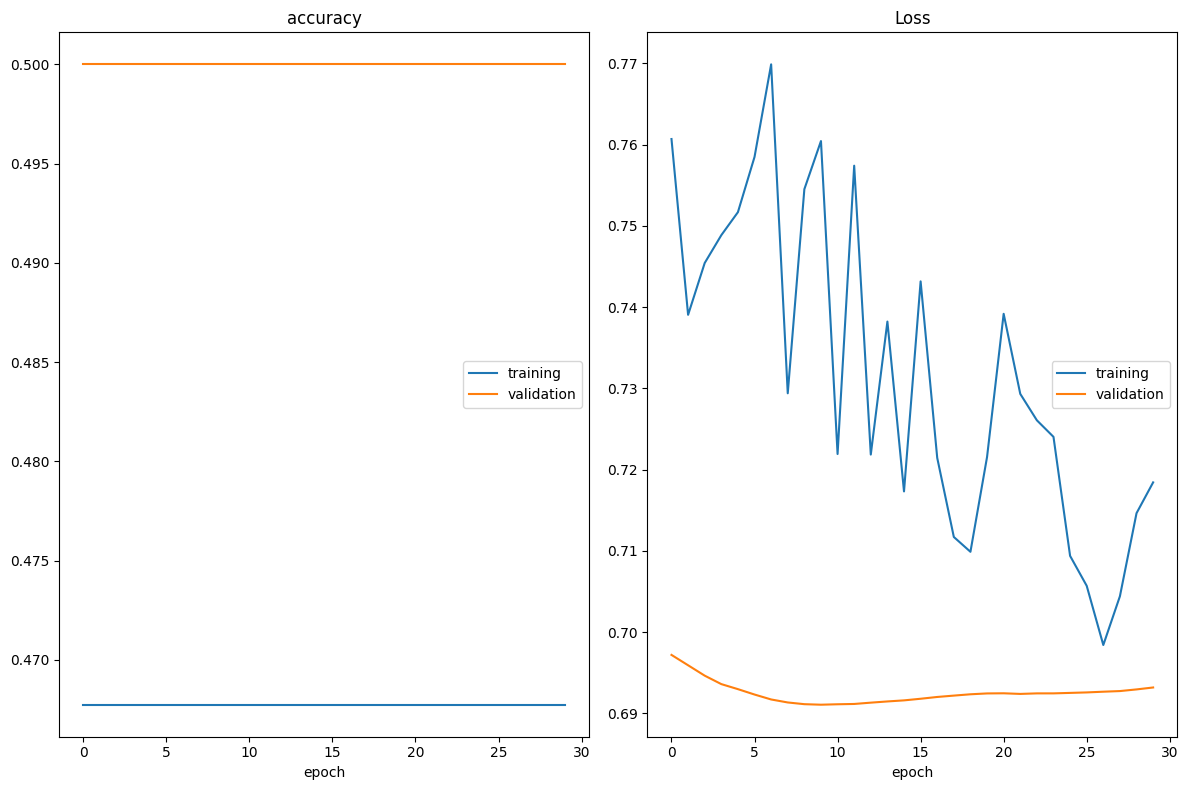

accuracy
	training         	 (min:    0.468, max:    0.468, cur:    0.468)
	validation       	 (min:    0.500, max:    0.500, cur:    0.500)
Loss
	training         	 (min:    0.698, max:    0.770, cur:    0.718)
	validation       	 (min:    0.691, max:    0.697, cur:    0.693)
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.4725 - loss: 0.7261 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 10.


In [12]:
nn_file = my_path + 'nn-sonar-dropoutkp_0.5-lr_0.0001.keras'
model = make_sequential_model(sample_size, deep_architecture,
                              loss_fun="binary_crossentropy",
                              learning_rate=0.0001,dropout_keep_prob=0.5)
history = train_model(model, nn_file, X_train, y_train, seed=seed_, max_epochs=800,
                      overwrite=True, patience=20)

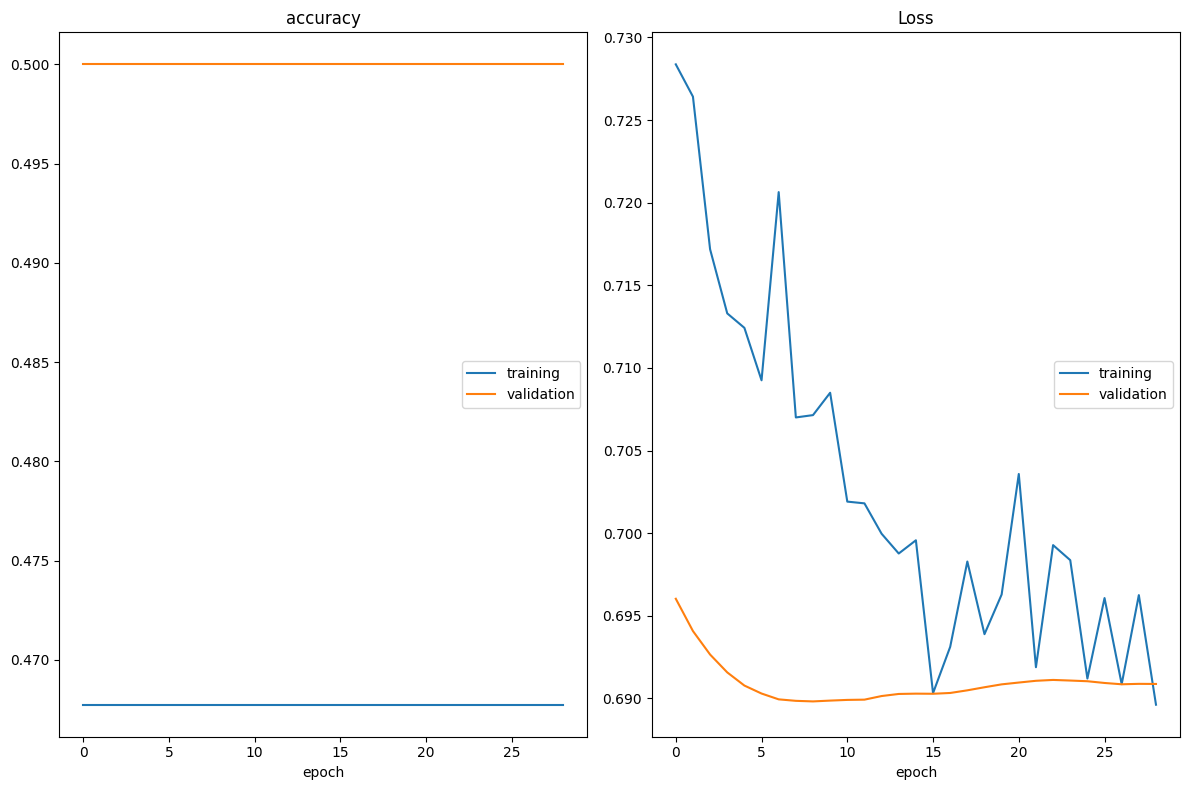

accuracy
	training         	 (min:    0.468, max:    0.468, cur:    0.468)
	validation       	 (min:    0.500, max:    0.500, cur:    0.500)
Loss
	training         	 (min:    0.690, max:    0.728, cur:    0.690)
	validation       	 (min:    0.690, max:    0.696, cur:    0.691)
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.4725 - loss: 0.6872 - val_accuracy: 0.5000 - val_loss: 0.6909
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 9.


In [13]:
nn_file = my_path + 'nn-sonar-dropoutkp_0.8-lr_0.0001.keras'
model = make_sequential_model(sample_size, deep_architecture,
                              loss_fun="binary_crossentropy",
                              learning_rate=0.0001,dropout_keep_prob=0.8)
history = train_model(model, nn_file, X_train, y_train, seed=seed_, max_epochs=800,
                      overwrite=True, patience=20)

# References

* [Ge19] Geron, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2019, O'Reilly